# Make plots of layer orientation

Requires master_orientation.py has already been run

## Import packages

In [71]:
# general
import numpy as np
import pandas as pd
import math
from scipy import stats

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# math
from statsmodels.stats.weightstats import DescrStatsW

## Load Data

In [72]:
alhic2302 = pd.read_pickle('../../data/angles/alhic2302_angles.df')
alhic2201 = pd.read_pickle('../../data/angles/alhic2201_angles.df')

## Calculate True Angle Orientations

In [73]:
# define function to calculate true dip, dip direction, and score

def calc_dip(df,face):

    dip = []
    dip_direction = []
    dip_score = []
    for index,row in df.iterrows():

        # pull out values from the side (first check there are three)
        if row['AC-'+face+'-angles'] != None and len(row['AC-'+face+'-angles']) > 2:
            add_nan = False
            side_angle = np.array(row['AC-'+face+'-angles']) * np.pi/180
            side_score = np.array(row['AC-'+face+'-scores'])
            side_length = np.array(row['AC-'+face+'-length'])
        else:
            add_nan = True

        # pull out values from the top
        if row['AC-t-angles'] != None and len(row['AC-t-angles']) > 2:
            top_angle = np.array(row['AC-t-angles']) * np.pi/180
            top_score = np.array(row['AC-t-scores'])
            top_length = np.array(row['AC-t-length'])
        else:
            add_nan = True
        

        # set true angle to nan if we don't have enough data

        if add_nan:
            dip_score_ind = [np.nan]
            dip_dir_ind = [np.nan]
            dip_ind = [np.nan]
        
        # else, calculate dip and save to list
        else:

            # assign delta 1 and delta 2
            if face == 'r':
                d1 = top_angle
                d2 = side_angle
                
                d1_score = top_score * top_length
                d2_score = side_score * side_length
            elif face == 'l':
                d1 = side_angle
                d2 = top_angle

                d1_score = side_score * side_length
                d2_score = top_score * top_length
            else:
                print('Error: face must be either t or l')
                break

            # make empty lists
            dip_score_ind = []
            dip_dir_ind = []
            dip_ind = []

            for i in range(len(d2)):
                for j in range(len(d1)):

                    # calculate dip score
                    ds = d1_score[j] * d2_score[i]
                    dip_score_ind.append(ds)

                    # calculate dip direction
                    dd = np.arctan(np.tan(d2[i])/np.tan(d1[j])) 
                    dip_dir_ind.append(dd* 180 / np.pi)

                    # calculate true dip
                    d = np.arctan(np.tan(d1[j])/np.cos(dd))
                    dip_ind.append(d* 180 / np.pi)


        # append to lists
        dip.append(dip_ind)
        dip_direction.append(dip_dir_ind)
        dip_score.append(dip_score_ind)

    df['AC-dip'] = dip
    df['AC-dip-direction'] = dip_direction
    df['AC-dip-score'] = dip_score

    return df

In [74]:
alhic2302 = calc_dip(alhic2302,'l')
alhic2201 = calc_dip(alhic2201,'r')


## Define function to get weighted percentile

In [75]:
def weighted_percentile(values, weights, percentiles):
    
    # Convert percentiles to fractions
    percentiles = [p / 100 for p in percentiles]

    # Convert values and weights to numpy arrays
    values = np.array(values)
    weights = np.array(weights)
    percentiles = np.array(percentiles)

    # Check for NaN values and remove them
    nan_mask = np.isnan(values) | np.isnan(weights)
    if np.any(nan_mask):
        print("NaN values found and will be removed.")
    values = values[~nan_mask]
    weights = weights[~nan_mask]
    
    # Sort values and weights by values
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    sorted_weights = weights[sorted_indices]
    
    # Compute the cumulative sum of weights
    cumulative_weights = np.cumsum(sorted_weights)
    
    # Normalize the cumulative weights to get the cumulative distribution
    cumulative_distribution = cumulative_weights / cumulative_weights[-1]
    
    # Interpolate to find the weighted percentiles
    weighted_percentiles = np.interp(percentiles, cumulative_distribution, sorted_values)
    
    return weighted_percentiles

## Calulate Percentiles

In [76]:
# define function to calculate percentiles from dataframe with true dip angles
def calc_percentiles(df,percentiles):

    # initialize list to store dip statistics
    dip_stats = []
    # define if we are looking at AC or DC (AC is default)
    ACorDC = 'AC'

    # loop through each row in the dataframe
    for index,row in df.iterrows():

        # pull out approriate data
        dip = np.array(row[ACorDC+'-dip'])
        scores = np.array(row[ACorDC+'-dip-score'])

        # check there isn't one value, indicating nan
        if len(dip)>1:
        
            # plot dip
            a = weighted_percentile(dip, scores, percentiles)
            # weighted_percentile(dip, percentiles, weights=scores, interpolation='step')
            dip_stats.append(a)

            # check
            for i in range(len(a)-1):
                if a[i]>a[i+1]:
                    print('Error: Percentiles are not in order in section '+row['section'])
        else:
            dip_stats.append([np.nan]*len(percentiles))

    df['dip_percentiles'] = dip_stats
    return df

In [77]:
#set percentiles
percentiles = [10,25,50,75,90]

# calculate true dip percentiles for alhic2201 and alhic2302
alhic2201 = calc_percentiles(alhic2201,percentiles)
alhic2302 = calc_percentiles(alhic2302,percentiles)

## Make a plot of depth vs dip

In [78]:
# define wisterplot function
def wiskerplot(d,q,axs,ACorDC):
    
    h = 0.8
    linewidth=1
    
    if ACorDC == 'AC':
        c = 'k'
        o = 0
    else:
        c = 'b'
        o = 0
        
    #box
    if q[1]<q[3]:
        axs.add_patch(Rectangle((q[1],d-h/2+o),(q[3]-q[1]),
                                h,
                                facecolor='r',
                                edgecolor='k',
                                linewidth=1))
    else:
        axs.add_patch(Rectangle((q[3],d-h/2+o),(360-q[3]),
                                h,
                                facecolor='r',
                                edgecolor='k',
                                linewidth=1))
        axs.add_patch(Rectangle((0,d-h/2+o),(q[1]),
                                h,
                                facecolor='r',
                                edgecolor='k',
                                linewidth=1))
    
    # centerline
    if q[0]<q[4]:
        axs.plot([q[0],q[-1]],[d+o,d+o],c,linewidth=linewidth)
    else:
        axs.plot([q[0],360],[d+o,d+o],c,linewidth=linewidth)
        axs.plot([0,q[4]],[d+o,d+o],c,linewidth=linewidth)

    # plot vertical lines at each quadrant
    axs.plot([q[0],q[0]],[d-h/4+o,d+h/4+o],c,linewidth=linewidth)
    axs.plot([q[2],q[2]],[d-h/2+o,d+h/2+o],c,linewidth=linewidth)
    axs.plot([q[4],q[4]],[d-h/4+o,d+h/4+o],c,linewidth=linewidth)

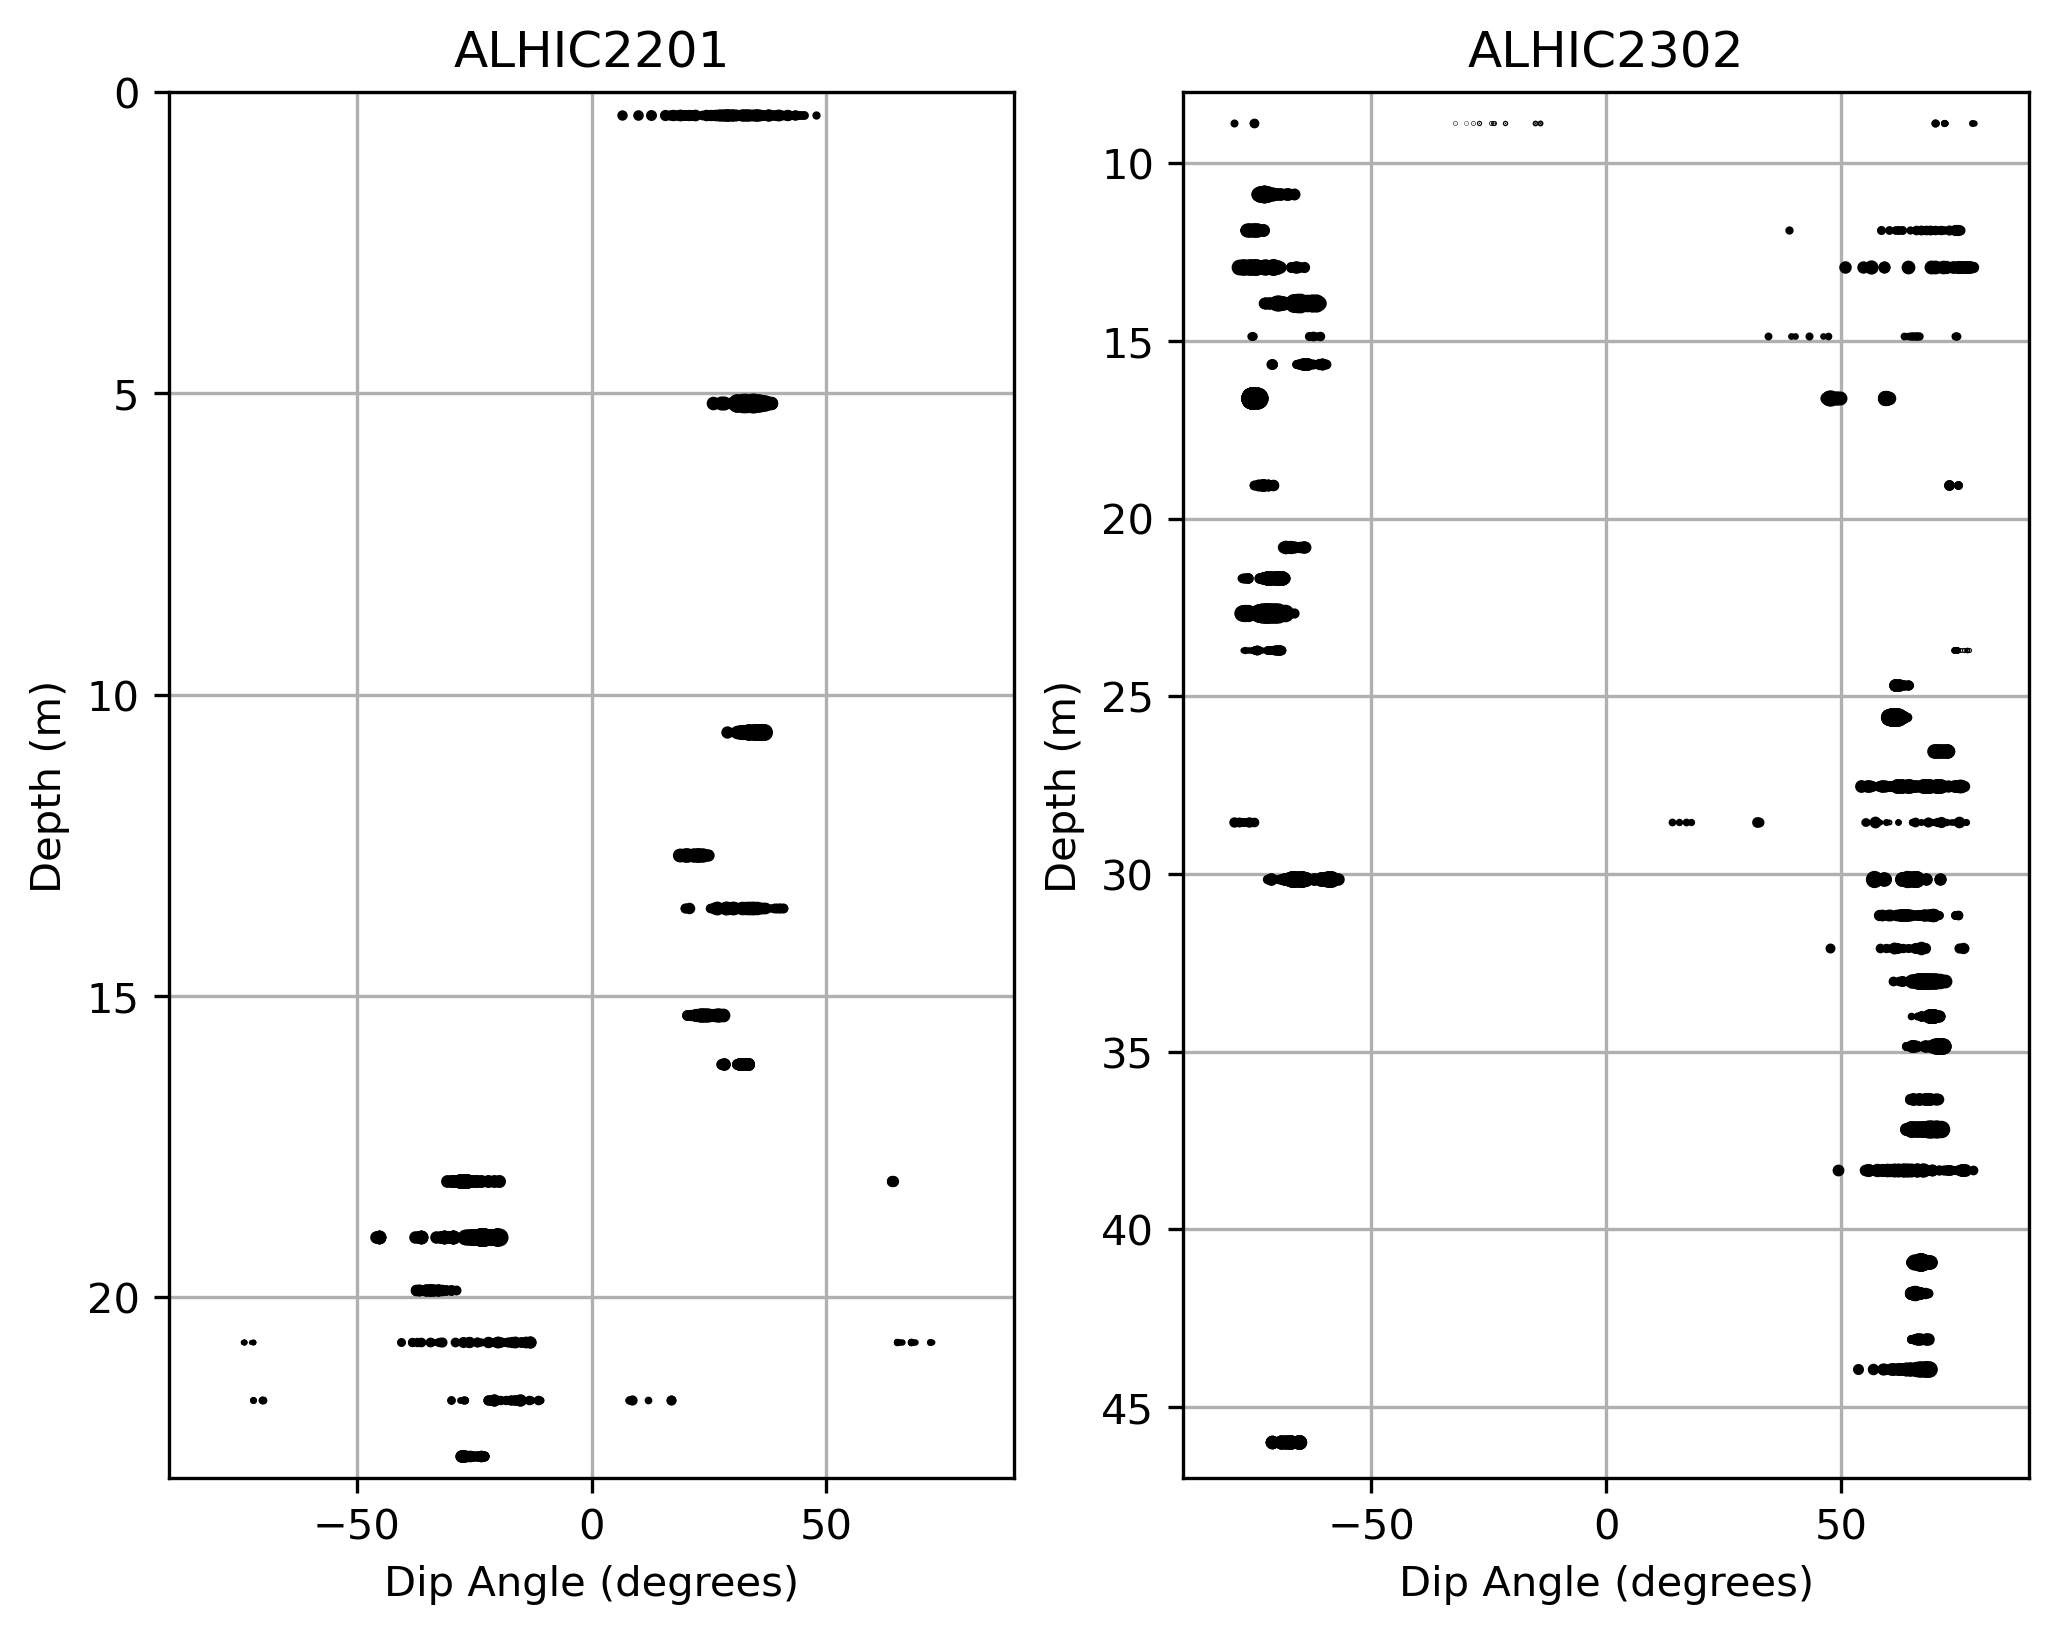

In [93]:
# make figure
fig, ax = plt.subplots(1,2,figsize=(8,6),dpi=300)

# axis labels
for a in ax:
    a.set_ylabel('Depth (m)')
    a.set_xlabel('Dip Angle (degrees)')
    a.set_xlim(-90,90)
    a.grid(True)
ax[0].set_title('ALHIC2201')
ax[1].set_title('ALHIC2302')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_ylim(23,0)
ax[1].set_ylim(47,8)

# plot data
for index,row in alhic2201.iterrows():

    d = row['depth']
    dip = np.array(row['AC-dip'])
    scores = np.array(row['AC-dip-score'])
    for i in range(len(dip)):
        ax[0].plot(dip[i],d,'k.',markersize=scores[i]*10)

for index,row in alhic2302.iterrows():
    d = row['depth']
    dip = np.array(row['AC-dip'])
    scores = np.array(row['AC-dip-score'])
    for i in range(len(dip)):
        ax[1].plot(dip[i],d,'k.',markersize=scores[i]*10)


In [80]:
for i in range(5-1):
    for j in range(i+1,5):
        print(i,j)

0 1
0 2
0 3
0 4
1 2
1 3
1 4
2 3
2 4
3 4


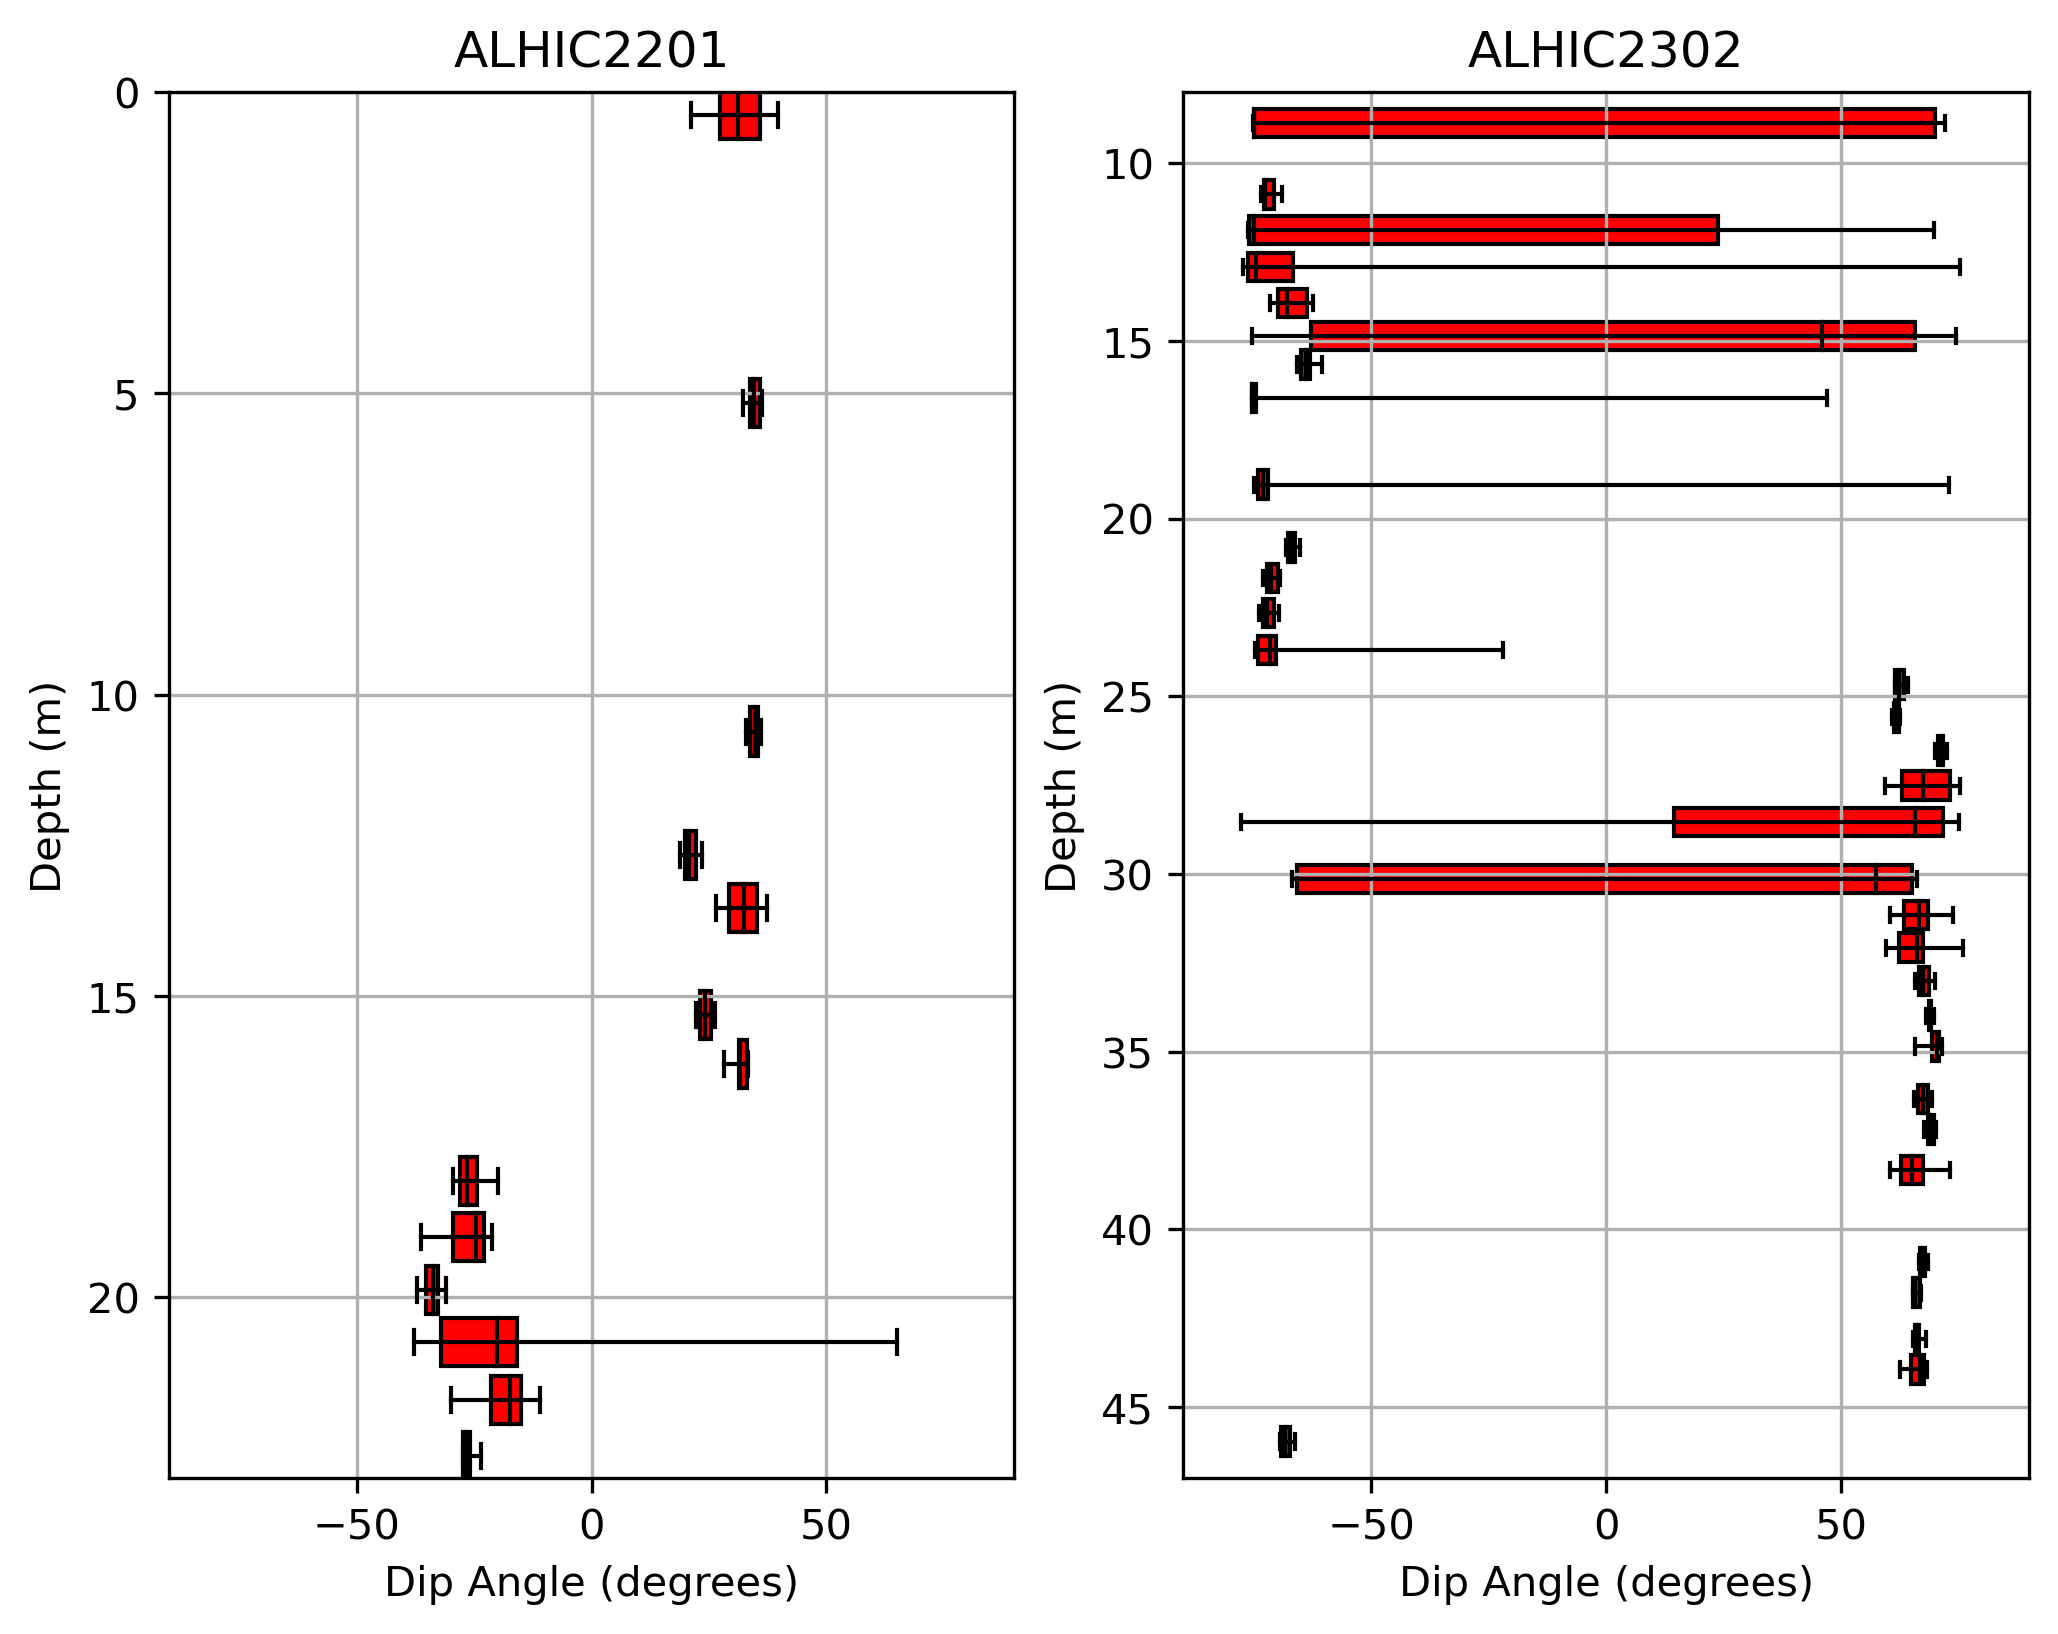

In [92]:
# make figure
fig, ax = plt.subplots(1,2,figsize=(8,6),dpi=300)

# axis labels
for a in ax:
    a.set_ylabel('Depth (m)')
    a.set_xlabel('Dip Angle (degrees)')
    a.set_xlim(-90,90)
    a.grid(True)
ax[0].set_title('ALHIC2201')
ax[1].set_title('ALHIC2302')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_ylim(23,0)
ax[1].set_ylim(47,8)

# plot data
for index,row in alhic2201.iterrows():

    d = row['depth']
    dip = np.array(row['AC-dip'])
    scores = np.array(row['AC-dip-score'])
    wiskerplot(d,row['dip_percentiles'],ax[0],'AC')
for index,row in alhic2302.iterrows():
    d = row['depth']
    dip = np.array(row['AC-dip'])
    scores = np.array(row['AC-dip-score'])
    wiskerplot(d,row['dip_percentiles'],ax[1],'AC')

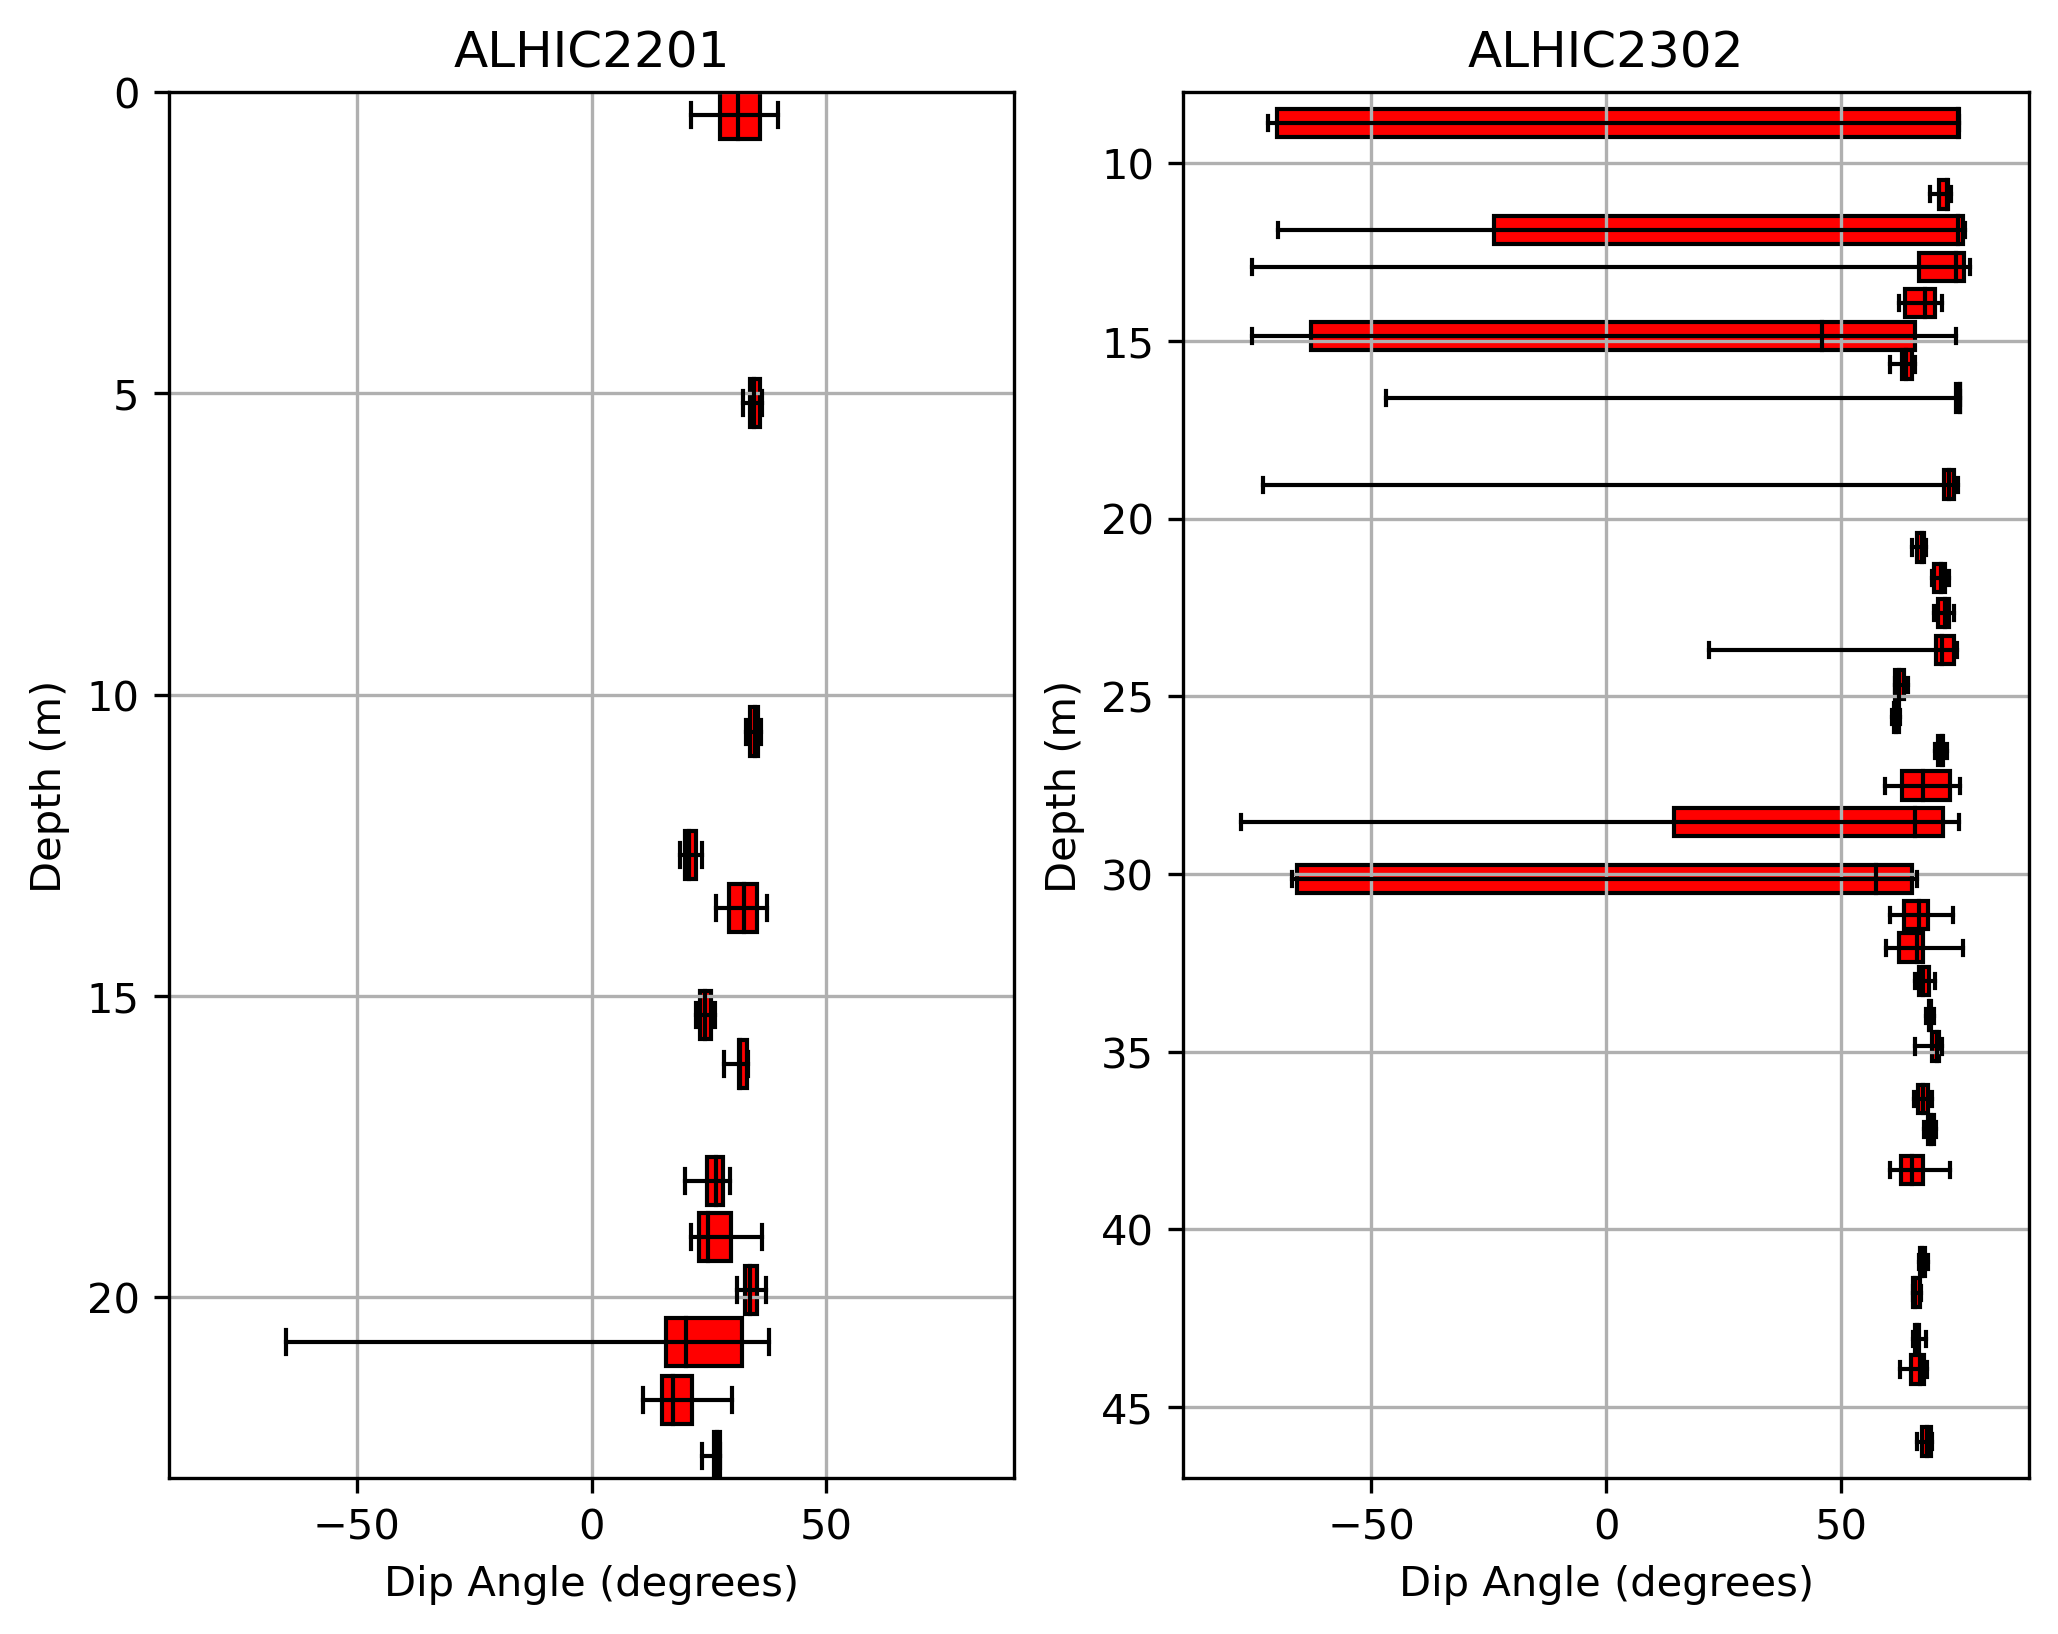

In [91]:
# make figure
fig, ax = plt.subplots(1,2,figsize=(8,6),dpi=300)

# axis labels
for a in ax:
    a.set_ylabel('Depth (m)')
    a.set_xlabel('Dip Angle (degrees)')
    a.set_xlim(-90,90)
    a.grid(True)
ax[0].set_title('ALHIC2201')
ax[1].set_title('ALHIC2302')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_ylim(23,0)
ax[1].set_ylim(47,8)

# plot data
for index,row in alhic2201.iterrows():

    d = row['depth']
    dip = np.array(row['AC-dip'])
    scores = np.array(row['AC-dip-score'])
    dip_percentile = row['dip_percentiles']
    if dip_percentile[2]<0:
        dip_percentile = np.flip(dip_percentile)
        dip_percentile = dip_percentile*-1
    
    wiskerplot(d,dip_percentile,ax[0],'AC')

for index,row in alhic2302.iterrows():
    d = row['depth']
    dip = np.array(row['AC-dip'])
    scores = np.array(row['AC-dip-score'])
    dip_percentile = row['dip_percentiles']
    if dip_percentile[2]<0:
        # flip dip percentile
        dip_percentile = np.flip(dip_percentile)
        dip_percentile = dip_percentile*-1
    wiskerplot(d,dip_percentile,ax[1],'AC')

## Make a plot showing dip direction

In [83]:
# function to calculate circular mean
def calc_circular_mean(df):

    for index,row in df.iterrows():
        
        # pull out approriate data
        angles = np.array(row['AC-dip-direction'])
        weights = np.array(row['AC-dip-score'])
        
        # convert to radians
        angles = np.radians(angles)
        
        # compute the mean
        x = np.sum(np.cos(angles)*weights)
        y = np.sum(np.sin(angles)*weights)
        
        # convert back to degrees
        mean = np.degrees(np.arctan2(y,x))

        # convert to 0-360
        if mean < 0:
            mean = mean + 360
        
        # store the circular mean
        df.loc[index,'dip-direction-mean'] = mean
    
    return df

In [84]:
# impliment function, calc circular mean
alhic2201 = calc_circular_mean(alhic2201)
alhic2302 = calc_circular_mean(alhic2302)

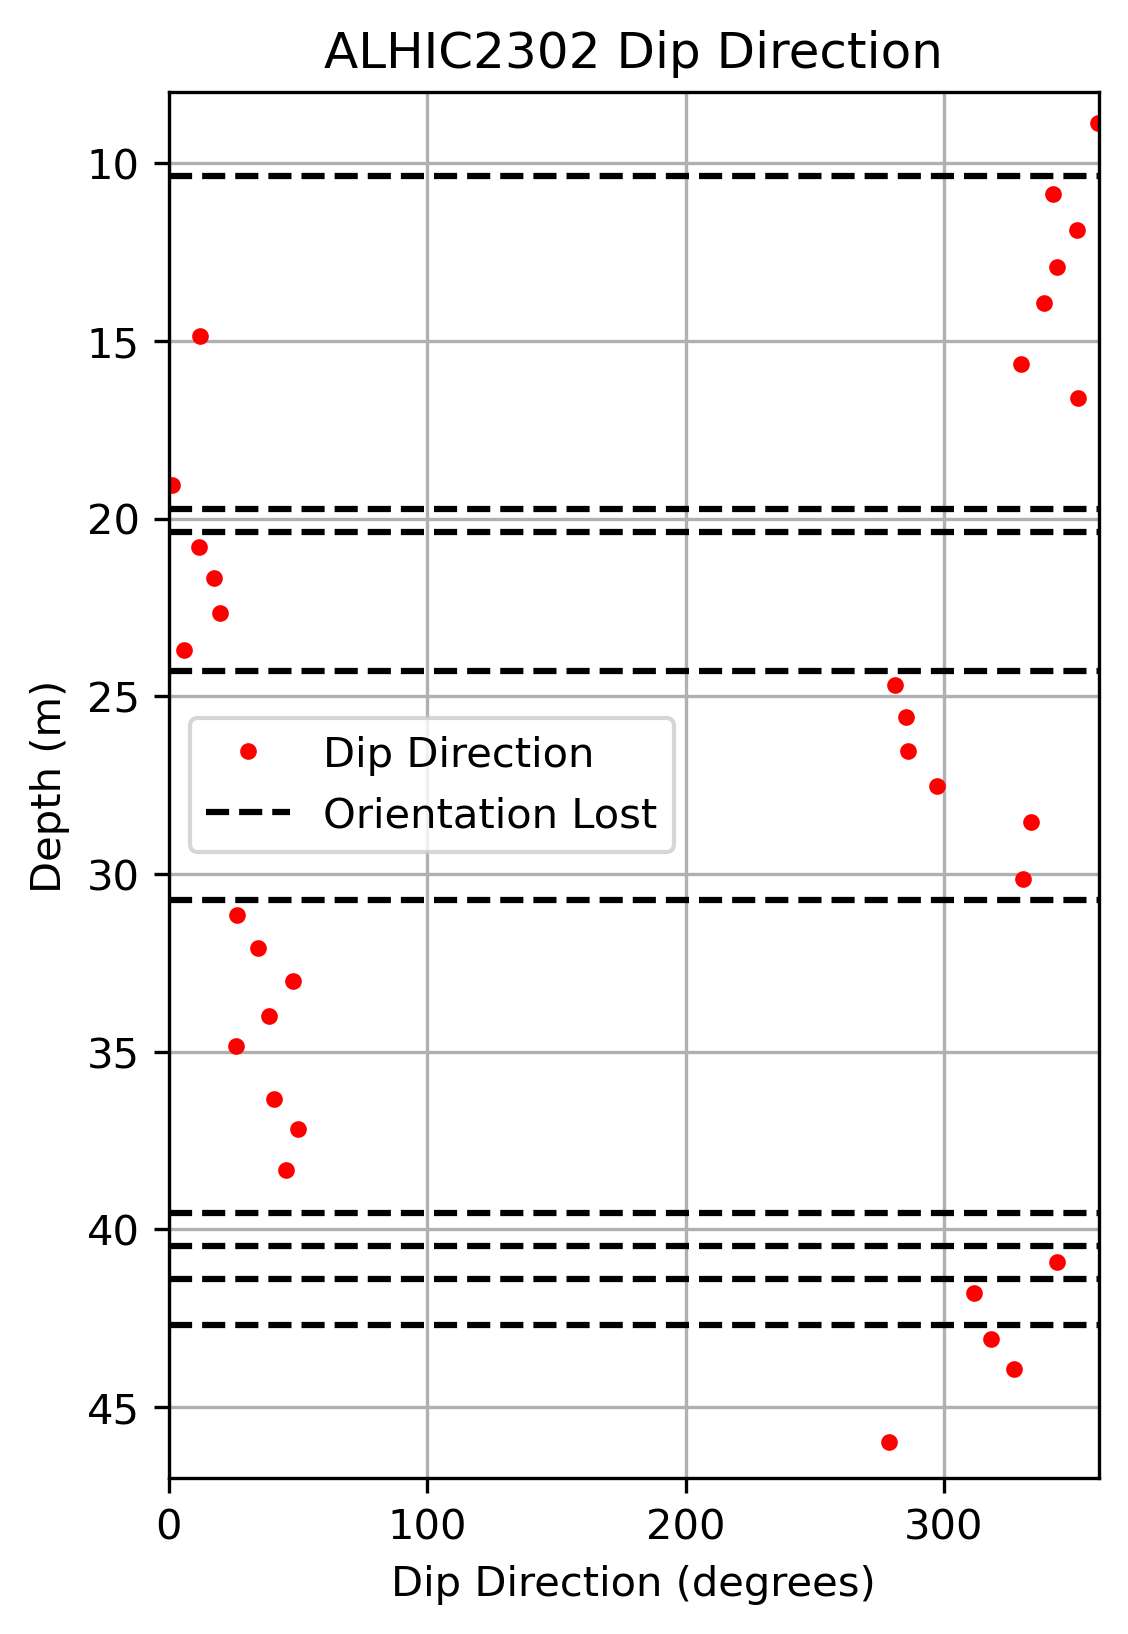

In [94]:
# define core breaks
alhic2201_breaks = [17.62,17.65,24.08]
alhic2302_breaks = [10.37,19.73,20.39,24.28,30.72,39.53,40.47,41.39,42.7]

# make figure
fig, ax = plt.subplots(1,1,figsize=(4,6),dpi=300)

ax.set_ylabel('Depth (m)')
ax.set_xlabel('Dip Direction (degrees)')
ax.grid(True)
ax.set_title('ALHIC2302 Dip Direction')
ax.set_xlim(0,360)
ax.set_ylim(47,8)

# plot dip directions
cnt = 0
for index,row in alhic2302.iterrows():
    d = row['depth']
    if cnt==0:
        ax.plot(row['dip-direction-mean'],d,'ro',markersize=3,label='Dip Direction')
    else:
        ax.plot(row['dip-direction-mean'],d,'ro',markersize=3)
    cnt+=1

# plot core breaks
cnt = 0
for b in alhic2302_breaks:
    if cnt ==0:
        ax.plot([0,360],[b,b],'k--',label='Orientation Lost')
    else:
        ax.plot([0,360],[b,b],'k--')
    cnt+=1

# add legend
ax.legend()

In [86]:
# Save Output Dataframe with simple angle information

# loop through both
for df,core in zip([alhic2201,alhic2302],['ALHIC2201','ALHIC2302']):
    print(core)

ALHIC2201
ALHIC2302


## Make Plot showing trend with depth

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


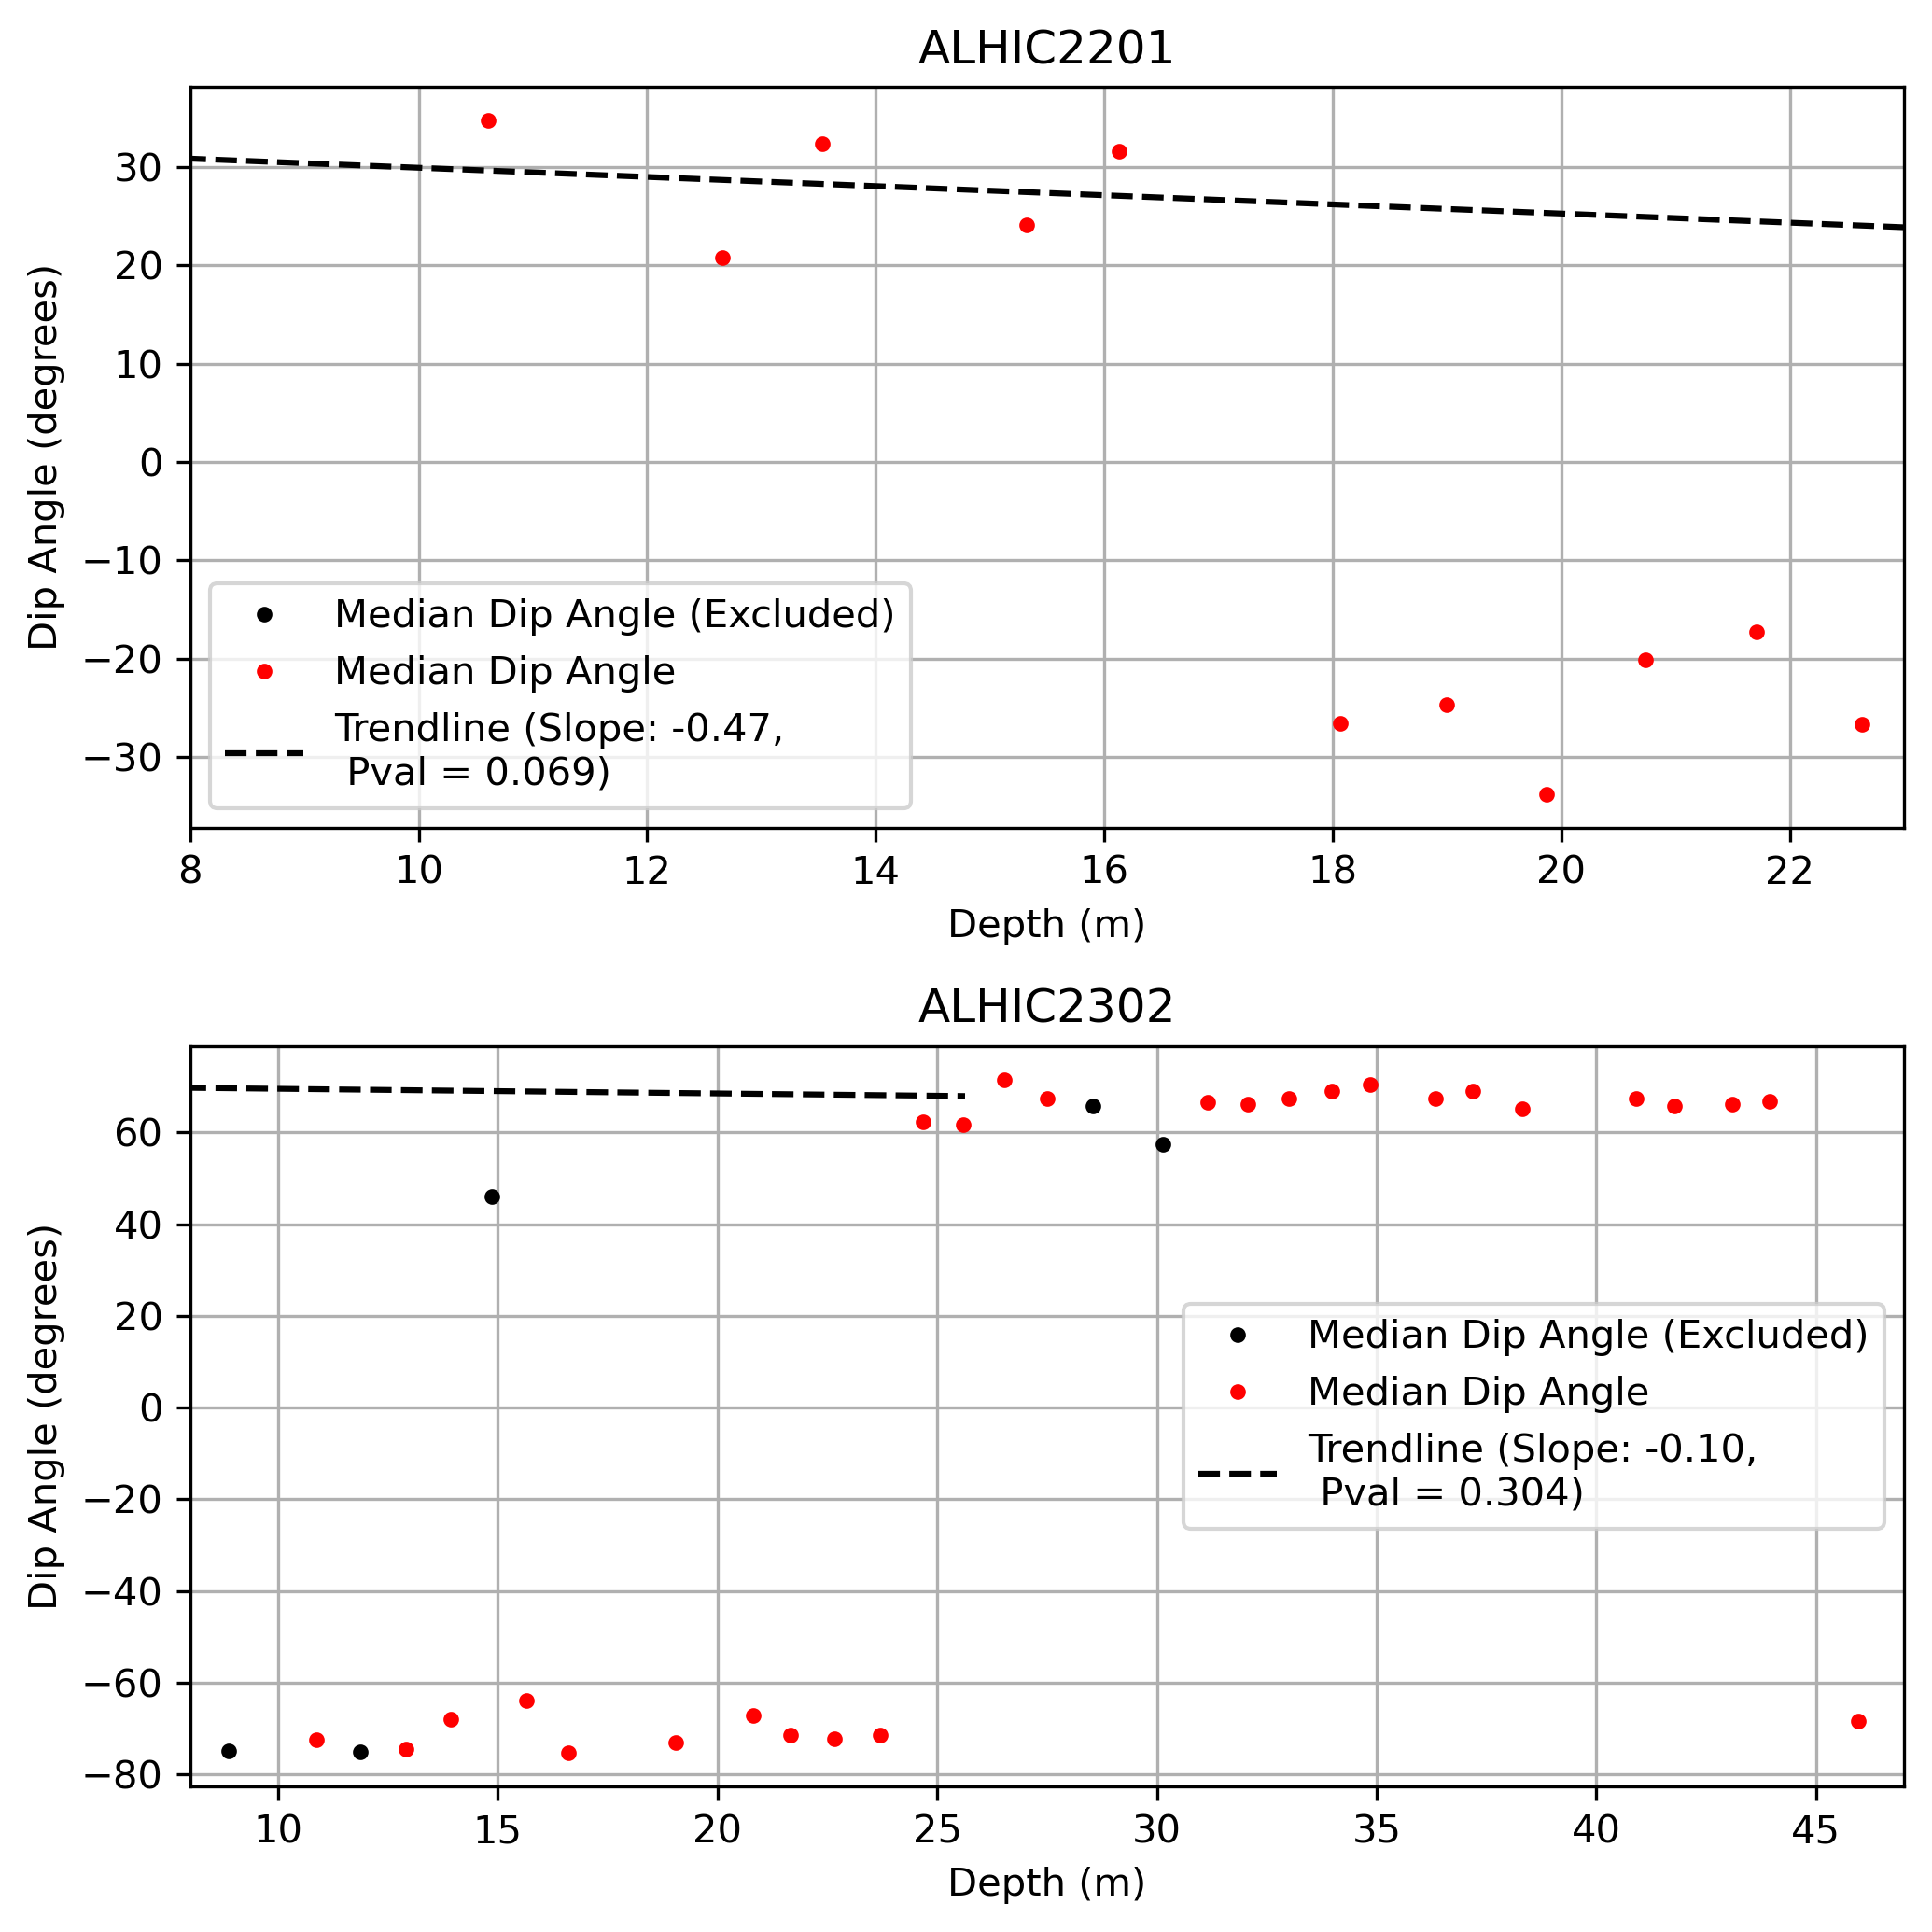

In [106]:
# set threshold to ignore
threshold = 20

def t_test_trend(df,threshold):

    # pull out median dip
    dip = np.array(df['dip_percentiles'].apply(lambda x:x[2]))
    q1 = np.array(df['dip_percentiles'].apply(lambda x:x[1]))
    q3 = np.array(df['dip_percentiles'].apply(lambda x:x[3]))

    # pull out depth and interquartile range
    depth = np.array(df['depth'])

    # remove nan from dip and depth vectors
    depth = depth[~np.isnan(dip)]
    q1 = q1[~np.isnan(dip)]
    q3 = q3[~np.isnan(dip)]
    dip = dip[~np.isnan(dip)]

    # pull out depth/dip values which exceed an interquartile range of 40
    depth = depth[abs(q3-q1)<threshold]
    dip = dip[abs(q3-q1)<threshold]

    # perform t-test
    slope, intercept, r_value, p_value, std_err = stats.linregress(depth,abs(dip))

    return slope,intercept,p_value,depth,dip

# calculate t-test for alhic2201 and alhic2302
slope2201,intercept2201,p_value2201,depth2201,dip2201 = t_test_trend(alhic2201,threshold)
slope2302,intercept2302,p_value2302,depth2302,dip2302 = t_test_trend(alhic2302,threshold)

# make figure
fig, ax = plt.subplots(2,1,figsize=(7,7),dpi=300)
for a in ax:
    a.set_xlabel('Depth (m)')
    a.set_ylabel('Dip Angle (degrees)')
    a.set_xlim(0,90)
    a.grid(True)
ax[0].set_title('ALHIC2201')
ax[1].set_title('ALHIC2302')
ax[0].set_xlim(8,23)
ax[1].set_xlim(8,47)

# plot data
#for ax,slope,intercept,p_value,depth,dip in zip(ax,[slope2201,slope2302],[intercept2201,intercept2302],[p_value2201,p_value2302],[depth2201,depth2302],[dip2201,dip2302]):

for ax,slope,intercept,p_value,df in zip(ax,[slope2201,slope2302],[intercept2201,intercept2302],[p_value2201,p_value2302],[alhic2201,alhic2302]):

    # plot data
    label1 = True
    label2 = True
    for index,row in df.iterrows():
        d = row['depth']
        dip = row['dip_percentiles'][2]
        q1 = row['dip_percentiles'][1]
        q3 = row['dip_percentiles'][3]
        if abs(q3-q1)<threshold:
            if label1:
                ax.plot(d,dip,'ro',markersize=3,label='Median Dip Angle')
                label1 = False
            else:
                ax.plot(d,dip,'ro',markersize=3)
        else:
            if label2:
                ax.plot(d,dip,'ko',markersize=3,label='Median Dip Angle (Excluded)')
                label2 = False
            else:
                ax.plot(d,dip,'ko',markersize=3)

    # plot trendline
    label = f'Trendline (Slope: {slope:.2f}, \n Pval = {p_value:.3f})'
    ax.plot([0,max(depth)+3],[intercept,intercept+slope*(max(depth)+3)],'k--', label=label)

    # add p-value
    #ax.text(0.1,0.9,'p = '+str(round(p_value,3)),transform=ax.transAxes)

    ax.legend()
plt.tight_layout()